In [1]:
import os
import pickle
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde

In [2]:
def scatter_plot(x, y, xlabel, ylabel, title):
    g = sns.JointGrid()
    sns.scatterplot(x=x, y=y, ax=g.ax_joint) # can set s=10
    sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x) 
    sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y)

    g.ax_joint.set(xlabel=xlabel, ylabel=ylabel)

    g.ax_joint.plot([np.min(x), np.max(x)], [np.min(x), np.max(x)], linewidth=1.0, color='black', linestyle='solid', label='Equality Line')

    X_mat=np.vstack((np.ones(len(x)), x)).T
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
    b,w = beta_hat[0],beta_hat[1]
    x2 = np.linspace(np.min(x),np.max(x),num=10)
    y2 = w * x2 + b

    g.ax_joint.plot(x2, y2, 'r--', linewidth=3.0, label='Linear Regression Line')
    g.ax_joint.legend()
    
    pearson_correlation = pearsonr(x,y)[0]

    g.ax_joint.text(np.max(x), np.min(y)+0.05*np.abs(np.min(y2)), 'R='+str(round(pearson_correlation,3)), horizontalalignment='right', fontsize='large')
    print("Reg Slope:", w)

    g.fig.suptitle(title, y=1.05)

    plt.show()

def scatter_plot_heatmap(x, y, xlabel, ylabel, title, equality_line=True, set_scale=False):
    
    x = x.to_numpy()
    y = y.to_numpy()
    
    fig = plt.figure(figsize=[7.2, 7.2])
    sns.set_style("darkgrid", {'image.cmap': u'plasma'})
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.scatter(x,y,c=z,s=50)
    if equality_line == True:
        plt.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality
    
    X_mat=np.vstack((np.ones(len(x)), x)).T
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
    b,w = beta_hat[0],beta_hat[1]
    x2 = np.linspace(np.min(x),np.max(x),num=10)
    y2 = w * x2 + b
    plt.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')
    
    pearson_correlation = pearsonr(x,y)[0]
#     plt.text(np.max(x), np.min(y)+0.05*np.abs(np.min(y2)), 'R='+str(round(pearson_correlation,3)), horizontalalignment='right', fontsize='large')
    
    if set_scale == True:
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        c_min, c_max = min(x_min, y_min), max(x_max, y_max)
        plt.xlim([c_min-2, c_max+2])
        plt.ylim([c_min-2, c_max+2])
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    lbl = 'Pearson R = '+str(round(pearson_correlation,3))
    plt.plot([],[],' ',label=lbl)
    
    plt.title(title)
    plt.legend()
    plt.show()
    
    
def get_corr_plot(array, title, labels, partial_correlation=False, fig_size=None, fix_colorbar_scale=False,
                 xlabel=None, ylabel=None):
    with sns.axes_style("white"):
        if fig_size == None:
            fig = plt.figure() # can set figsize=(fig_size = 12.8, fig_size)
        else:
            fig = plt.figure(figsize=(fig_size, fig_size))
        ax = fig.add_subplot(111)
        if fix_colorbar_scale == True:
            cax = ax.matshow(array, interpolation='nearest',cmap='viridis', vmin=0, vmax=1)
        else:
            cax = ax.matshow(array, interpolation='nearest',cmap='viridis')
        fig.colorbar(cax)
        if partial_correlation == False:
            intro = "Pearson R"
        else:
            intro = "Partial Correlation"
        plt.title("{} for {}".format(intro, title), fontsize=fig_size+5 if fig_size != None else 10)
        ax.set_yticks(np.arange(len(labels)))
        ax.set_yticklabels(labels)
        ax.xaxis.set_ticks_position("bottom")
        ax.set_xticks(np.arange(len(labels)))
        ax.set_xticklabels(labels, rotation=90)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        if ylabel is not None:
            ax.set_ylabel(ylabel)
        plt.show()

def correlation_plot(df, key, title, partial_correlation= False, fig_size=None, fix_colorbar_scale=False):
    
    names = df.modality.to_list()
    
    if partial_correlation == False:
        corr_df1 = []
        for idx1 in range(len(df)):
            df1 = df.iloc[idx1].dataframe
            corr_df2 = []
            for idx2 in range(len(df)):
                df2 = df.iloc[idx2].dataframe
                r, _ = pearsonr(df1[key], df2[key])
                corr_df2.append(r)
            corr_df2 = np.array(corr_df2).astype('float32')
            corr_df1.append(corr_df2)
        corr_df1 = np.array(corr_df1).astype('float32')
        get_corr_plot(corr_df1, labels=names, partial_correlation=partial_correlation,
                      title=title, fig_size=fig_size, fix_colorbar_scale=fix_colorbar_scale) 
    else:
        tmp_dct = {}
        for idx in range(len(df)):
            tmp_df = df.iloc[idx].dataframe[key]
            tmp_dct[names[idx]] = tmp_df.to_numpy()
        pcorr_df = pd.DataFrame.from_dict(tmp_dct)
        del tmp_dct, tmp_df
        
        # This implementation comes from https://pingouin-stats.org/index.html
        # Source code here for pcorr: https://github.com/raphaelvallat/pingouin/blob/72e447d539f8cfbd6b9c9c5041e267de748fe124/pingouin/correlation.py

        V = pcorr_df.cov()
        Vi = np.linalg.pinv(V, hermitian=True)
        D = np.diag(np.sqrt(1 / np.diag(Vi)))
        pcor = -1 * (D @ Vi @ D)
        pcor[np.diag_indices_from(pcor)] = 1
        get_corr_plot(pcor, labels=names, partial_correlation=partial_correlation,
                      title=title, fig_size=fig_size, fix_colorbar_scale=fix_colorbar_scale) 
        
def kde_plot(x, y, xlabel, ylabel, title):
    plt.figure()
    sns.kdeplot(x, label='Ground Truth')
    sns.kdeplot(y, label= ylabel)
    plt.legend()
    plt.title(title)

In [6]:
# df = pd.read_pickle('female_test_prototype.pkl')
# df = pd.read_pickle('female_test_testB_convergence9.pkl')
df1 = pd.read_pickle('female_test_testB_CNN_noise_retrain.pkl')
# df2 = pd.read_pickle('female_test_testB_SWIN_noise.pkl')

noiseSTD = [
    0.0, 0.04, 0.08, 0.12, 0.16, 0.2
]
# df = pd.read_pickle('female_train.pkl')
# df = pd.read_pickle('female_testA.pkl')

In [7]:
df1.iloc[0].dataframe

Unnamed: 0  target_age  output_age_1  age_delta_1     loss_1  \
0       24237795   77.280940     77.093580    -0.187355   0.035102   
1       25463415   58.056694     60.484573     2.427879   5.894598   
2       25313661   59.653084     58.366810    -1.286274   1.654501   
3       23521455   53.088700     52.809720    -0.278980   0.077830   
4       25206481   50.428654     54.026783     3.598129  12.946534   
...          ...         ...           ...          ...        ...   
2505    25785977   55.227055     62.588013     7.360958  54.183704   
2506    25068363   61.883446     64.046234     2.162788   4.677654   
2507    22834218   60.501940     60.865906     0.363964   0.132470   
2508    24442683   56.130707     54.951490    -1.179218   1.390556   
2509    24018656   51.958560     55.617153     3.658592  13.385297   

      output_age_2  age_delta_2     loss_2  output_age_3  age_delta_3  ...  \
0        74.797660    -2.483276   6.166662     76.159775    -1.121162  ...   
1        60.233345     2.176651   4.737810     61.228527     3.171833  ...   
2        58.327538    -1.325546   1.757073     62.249590     2.596508  ...   
3        56.901000     3.812302  14.533644     54.759216     1.670517  ...   
4        55.404000     4.975346  24.754065     51.149550     0.720898  ...   
...            ...          ...        ...           ...          ...  ...   
2505     63.079650     7.852596  61.663270     62.579563     7.352508  ...   
2506     65.126120     3.242676  10.514946     62.013145     0.129700  ...   
2507     62.196037     1.694096   2.869960     58.395954    -2.105987  ...   
2508     54.934890    -1.195816   1.429976     56.700146     0.569439  ...   
2509     56.841164     4.882603  23.839810     55.979740     4.021179  ...   

      output_age_decon_2  age_delta_decon_2  output_age_decon_3  \
0              79.722719           2.441779           82.715940   
1              58.844487           0.787793           61.015527   
2              56.112475          -3.540609           62.499495   
3              54.067505           0.978805           51.613318   
4              51.921526           1.492872           46.367189   
...                  ...                ...                 ...   
2505           62.924721           7.697666           62.979063   
2506           65.858376           3.974930           62.155856   
2507           61.658045           1.156105           56.898791   
2508           51.249048          -4.881659           54.434179   
2509           53.981729           2.023169           53.387173   

      age_delta_decon_3  output_age_decon_4  age_delta_decon_4  \
0              5.435000           77.901948           0.621008   
1              2.958833           58.391691           0.334997   
2              2.846411           59.225479          -0.427605   
3             -1.475382           50.968430          -2.120270   
4             -4.061465           54.929629           4.500975   
...                 ...                 ...                ...   
2505           7.752008           68.642702          13.415647   
2506           0.272410           68.990448           7.107002   
2507          -3.603149           64.614547           4.112607   
2508          -1.696528           57.782962           1.652255   
2509           1.428613           54.763578           2.805018   

      output_age_decon_5  age_delta_decon_5  output_age_decon_6  \
0              75.854222          -1.426718           82.446431   
1              65.181186           7.124492           60.723305   
2              58.917242          -0.735842           58.827149   
3              54.928900           1.840200           48.955216   
4              49.003975          -1.424679           49.968313   
...                  ...                ...                 ...   
2505           59.648111           4.421056           56.918199   
2506           63.537787           1.654341           67.754637   
2507           65.378872   

In [8]:
# # correlation_plot(df, key='mean_output_age', title='Mean Output Age', fig_size=20)
# # correlation_plot(df, key='mean_age_delta', title='Mean Age Delta', fig_size=20)
# # correlation_plot(df, key='output_age_decon', title='Output Age Deconfounded', fig_size=20)
# correlation_plot(df, key='age_delta_decon', title='Age Delta Debiased', 
#                  partial_correlation=False, fig_size=20)
# # correlation_plot(df, key='age_delta_decon', title='Age Delta Deconfounded', fig_size=20, 
# #                  partial_correlation=False, fix_colorbar_scale=True)

# # correlation_plot(df, key='mean_output_age', title='Mean Output Age', fig_size=20)
# # correlation_plot(df, key='mean_age_delta', title='Mean Age Delta', fig_size=20)
# # correlation_plot(df, key='output_age_decon', title='Output Age Deconfounded', fig_size=20)
# # correlation_plot(df, key='age_delta_decon', title='Age Delta Debiased', 
# #                  partial_correlation=False, fig_size=20)
# # correlation_plot(df, key='age_delta_decon', title='Age Delta Deconfounded', fig_size=20, 
# #                  partial_correlation=False, fix_colorbar_scale=True)

In [9]:
# correlation_plot(df, key='age_delta_decon', title='Age Delta Debiased', 
#                  partial_correlation=True, fig_size=20)
# # correlation_plot(df, key='age_delta_decon', title='Age Delta Deconfounded', fig_size=20, 
# #                  partial_correlation=True, fix_colorbar_scale=True)

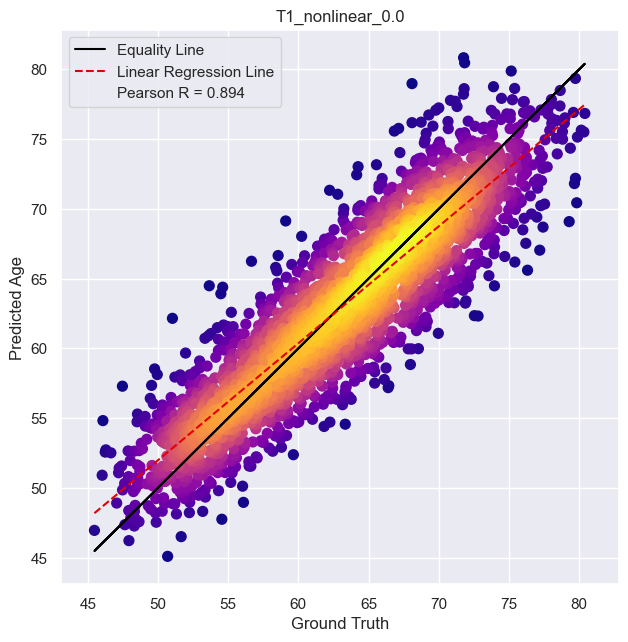

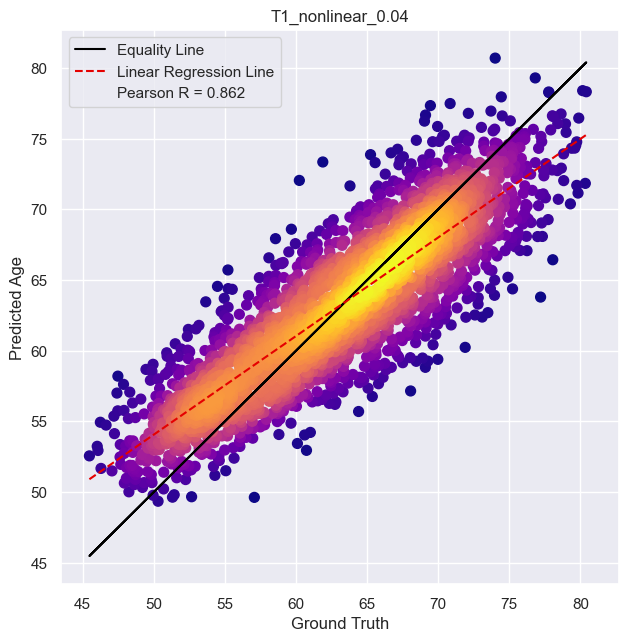

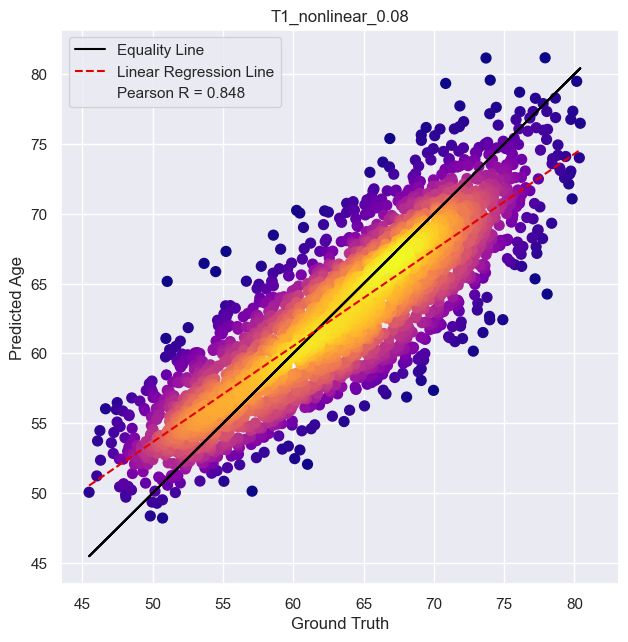

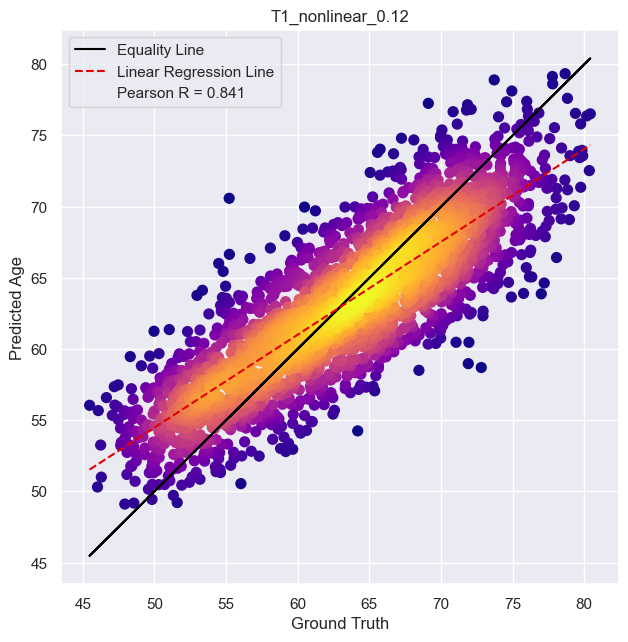

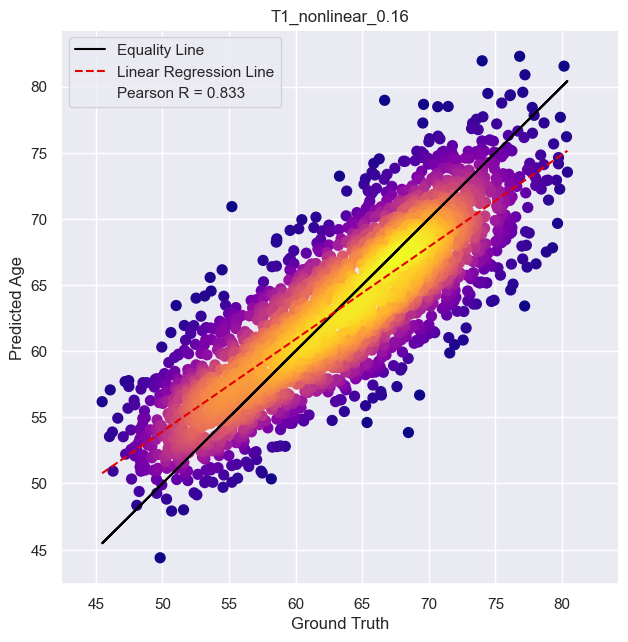

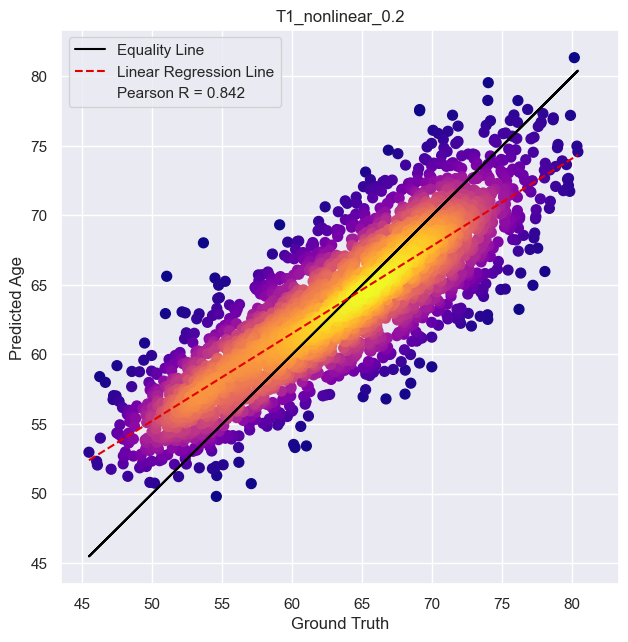

In [11]:
for idx in range(len(df1)):
    for idx2 in range(1,7):
        df_mod = df1.iloc[idx].dataframe
        name_mod = df1.iloc[idx].modality
        y_name = 'output_age_' + str(idx2)
#         y_name = 'output_age_decon_' + str(idx2)
#         y_name = 'age_delta_' + str(idx2)
#         y_name = 'age_delta_decon' + str(idx2)
        fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod[y_name], xlabel='Ground Truth', 
                                   ylabel='Predicted Age', title=name_mod + '_' + str(noiseSTD[idx2-1]), set_scale=True)

# for idx in range(len(df)):
#     df_mod = df.iloc[idx].dataframe
#     name_mod = df.iloc[idx].modality
#     fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod.output_age, xlabel='Ground Truth', 
#                                ylabel='Predicted Age', title=name_mod, set_scale=True)

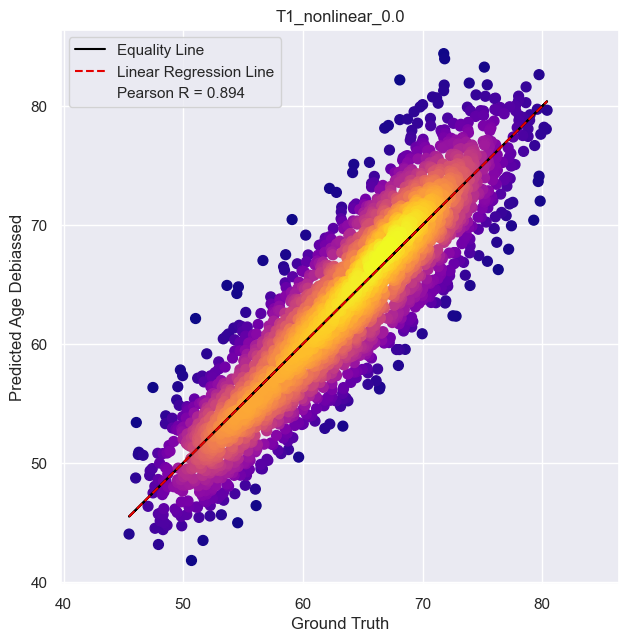

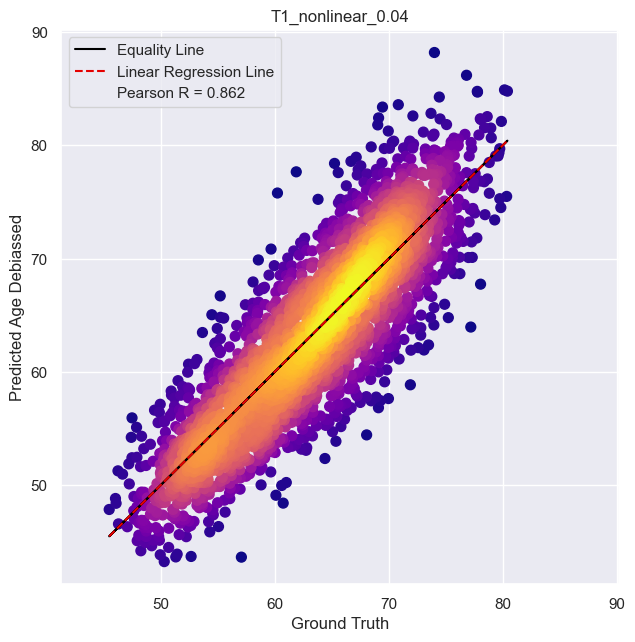

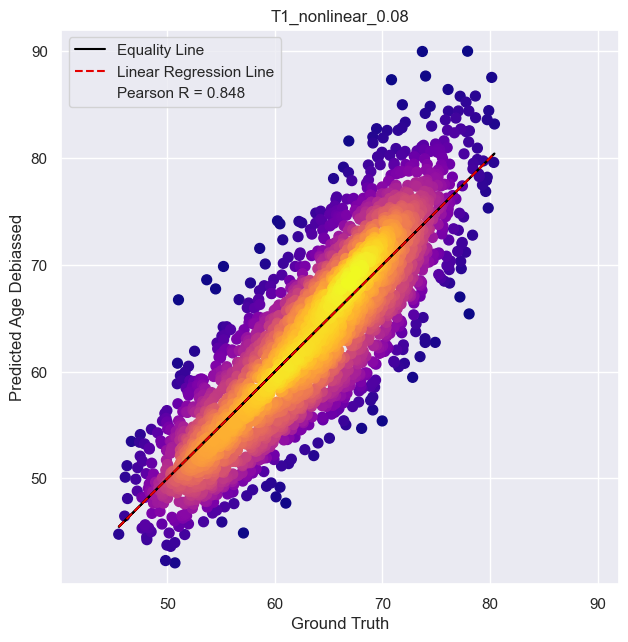

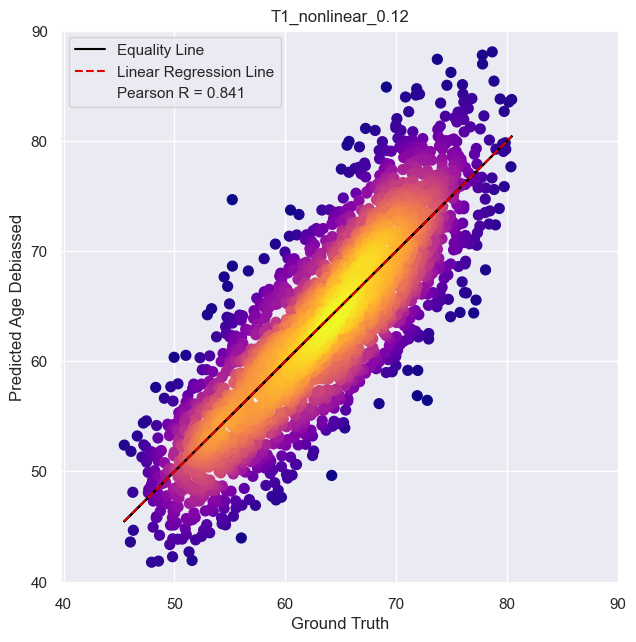

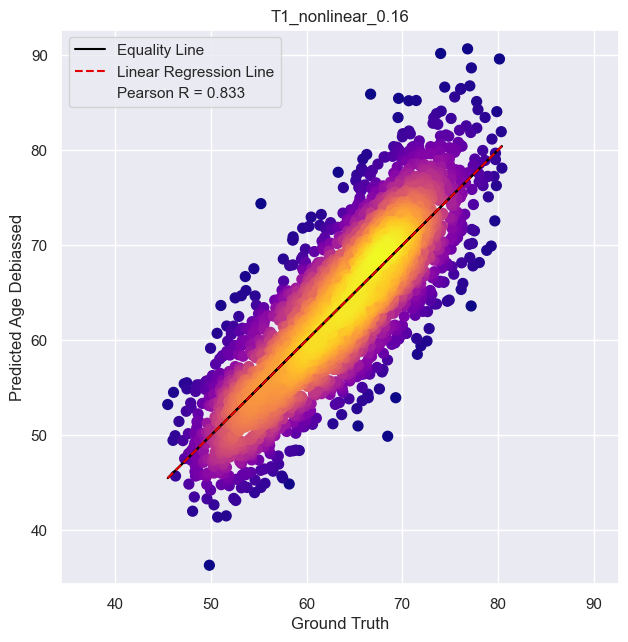

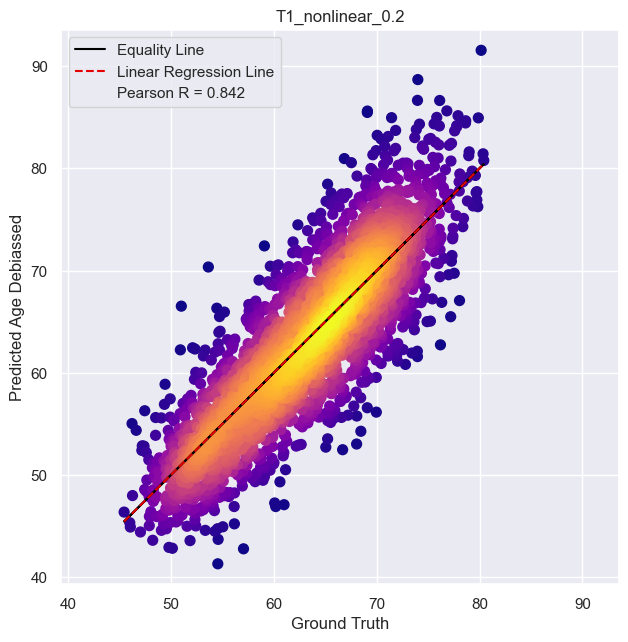

In [12]:
for idx in range(len(df1)):
    for idx2 in range(1,7):
        df_mod = df1.iloc[idx].dataframe
        name_mod = df1.iloc[idx].modality
#         y_name = 'output_age_' + str(idx2)
        y_name = 'output_age_decon_' + str(idx2)
#         y_name = 'age_delta_' + str(idx2)
#         y_name = 'age_delta_decon' + str(idx2)
        fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod[y_name], xlabel='Ground Truth', 
                                   ylabel='Predicted Age Debiassed', title=name_mod + '_' + str(noiseSTD[idx2-1]), set_scale=True)



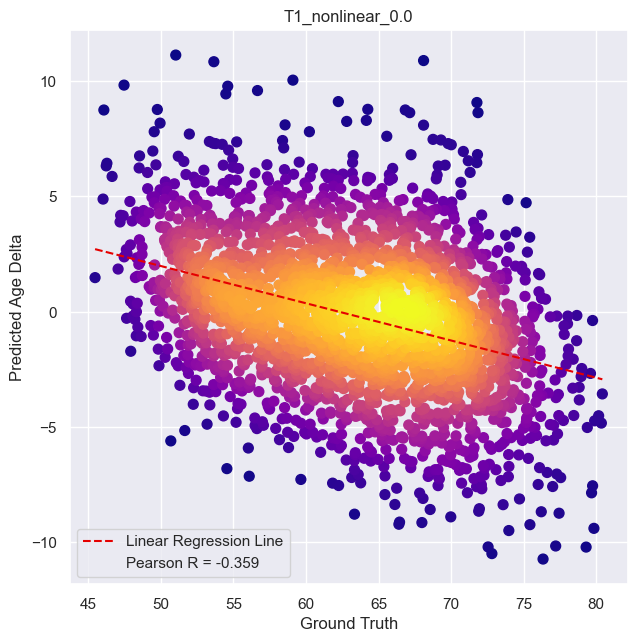

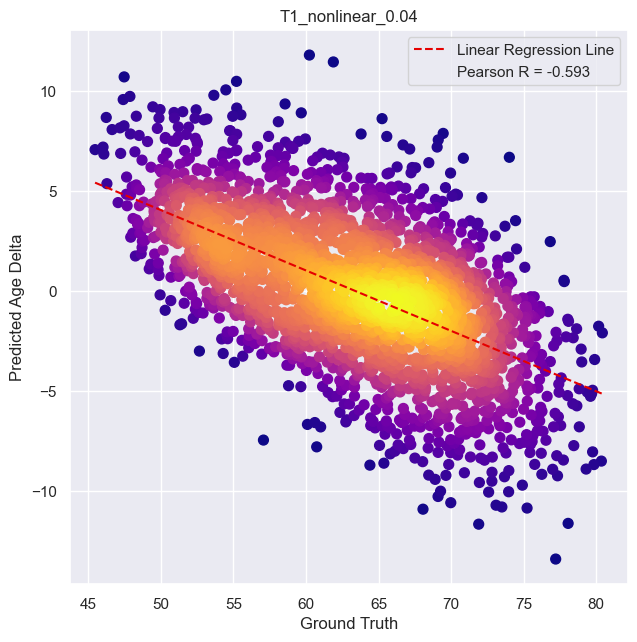

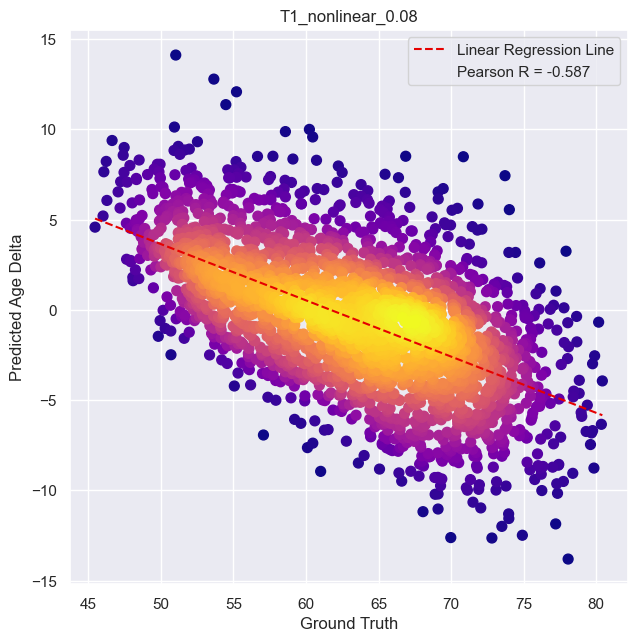

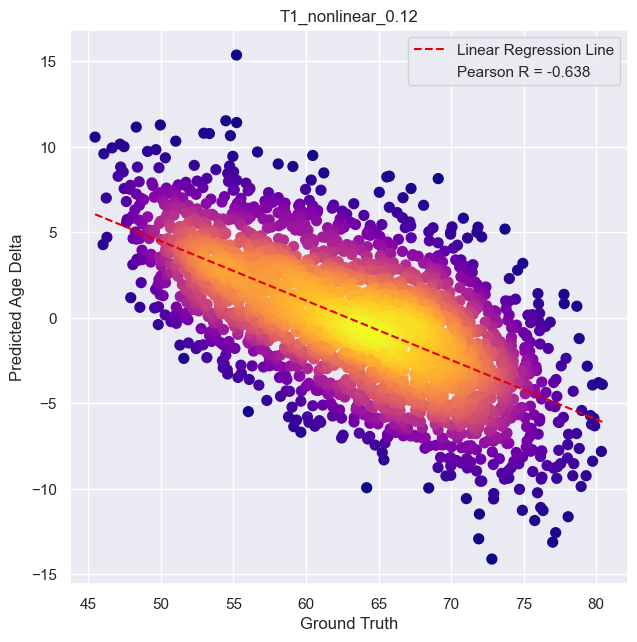

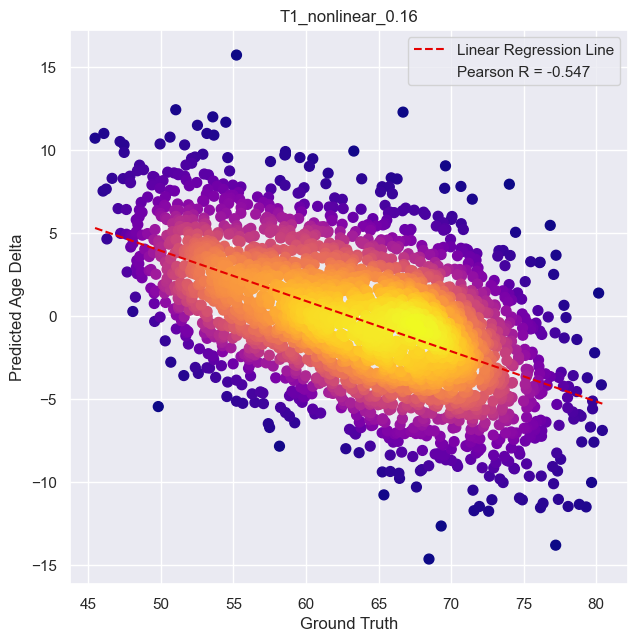

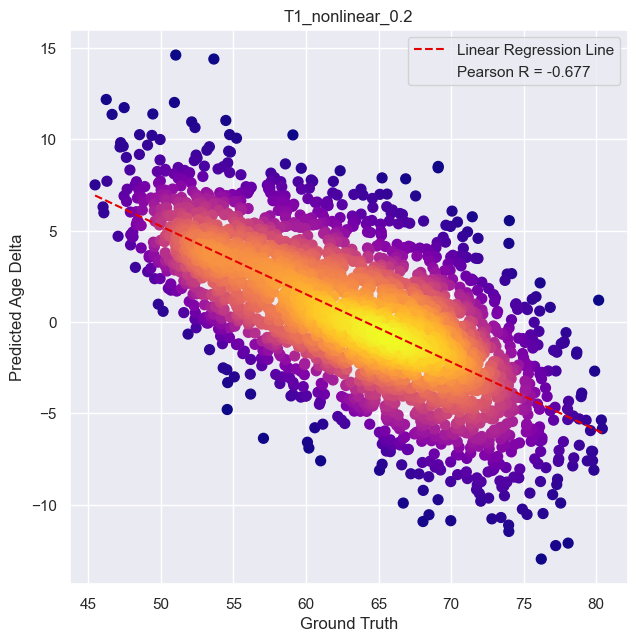

In [13]:
for idx in range(len(df1)):
    for idx2 in range(1,7):
        df_mod = df1.iloc[idx].dataframe
        name_mod = df1.iloc[idx].modality
#         y_name = 'output_age_' + str(idx2)
#         y_name = 'output_age_decon_' + str(idx2)
        y_name = 'age_delta_' + str(idx2)
#         y_name = 'age_delta_decon' + str(idx2)
        fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod[y_name], xlabel='Ground Truth', 
                                   ylabel='Predicted Age Delta', title=name_mod + '_' + str(noiseSTD[idx2-1]), 
                                   set_scale=False, equality_line=False)



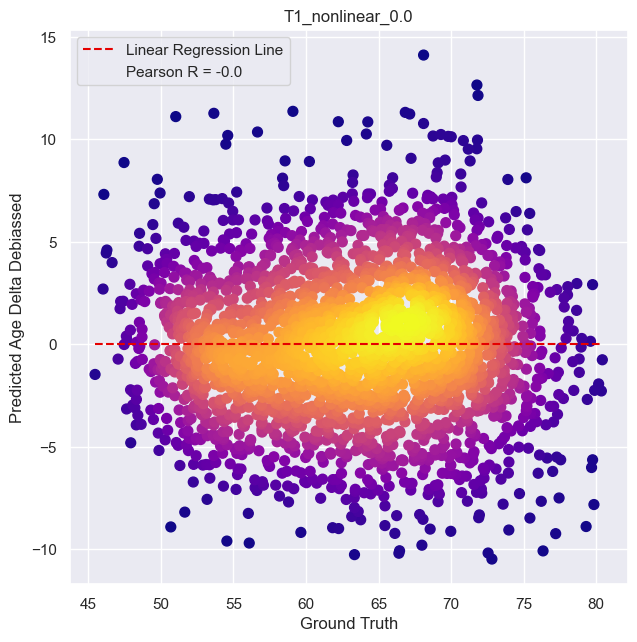

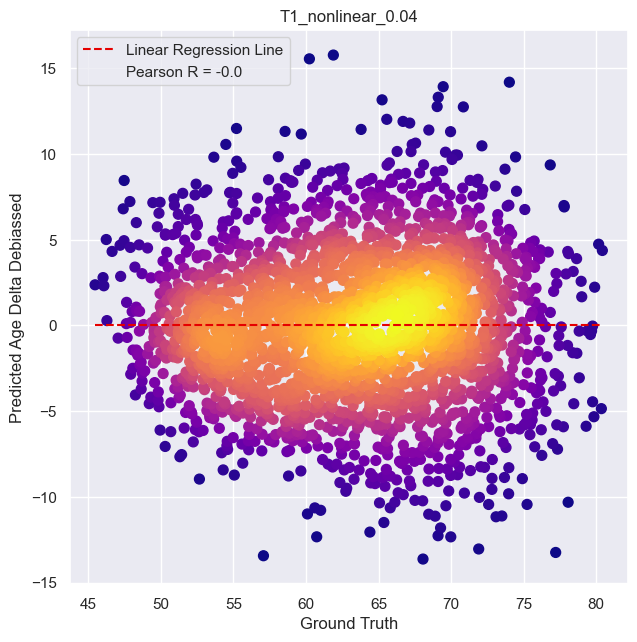

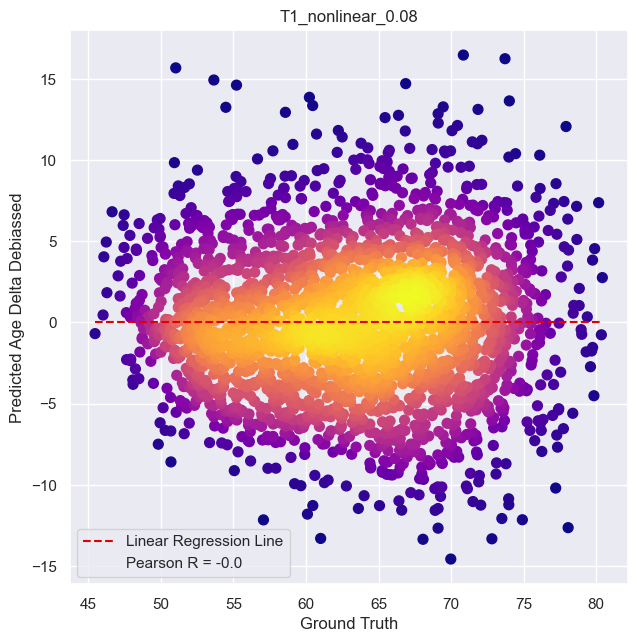

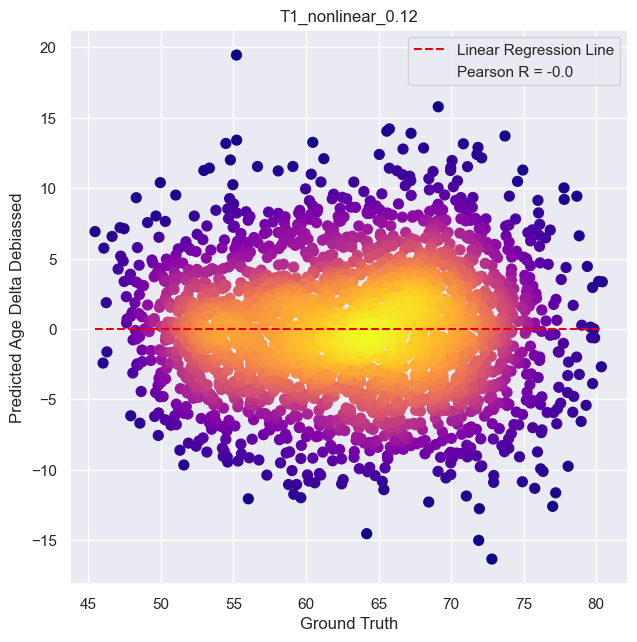

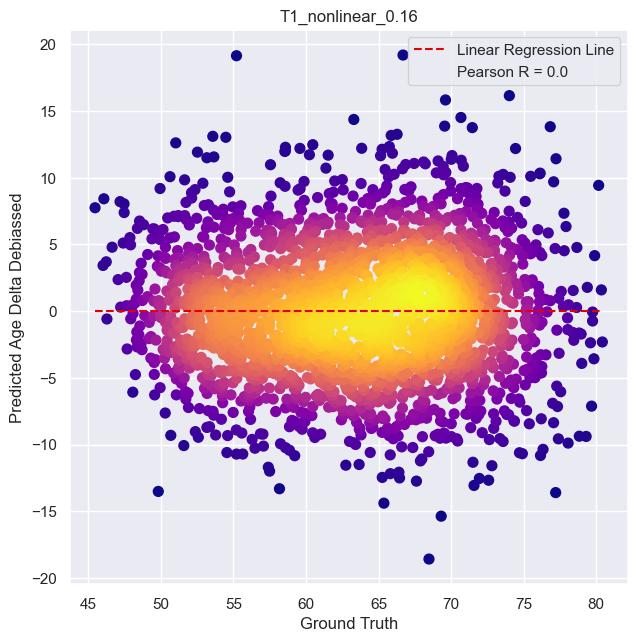

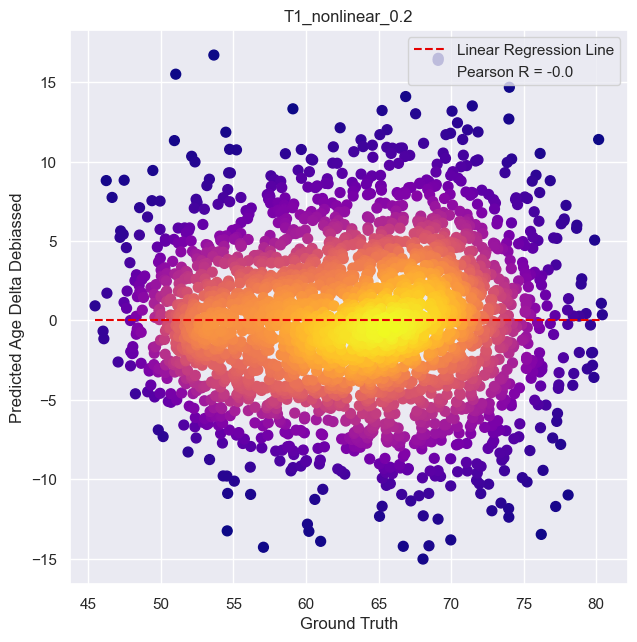

In [14]:
for idx in range(len(df1)):
    for idx2 in range(1,7):
        df_mod = df1.iloc[idx].dataframe
        name_mod = df1.iloc[idx].modality
#         y_name = 'output_age_' + str(idx2)
#         y_name = 'output_age_decon_' + str(idx2)
#         y_name = 'age_delta_' + str(idx2)
        y_name = 'age_delta_decon_' + str(idx2)
        fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod[y_name], xlabel='Ground Truth', 
                                   ylabel='Predicted Age Delta Debiassed', title=name_mod + '_' + str(noiseSTD[idx2-1]), 
                                   set_scale=False, equality_line=False)



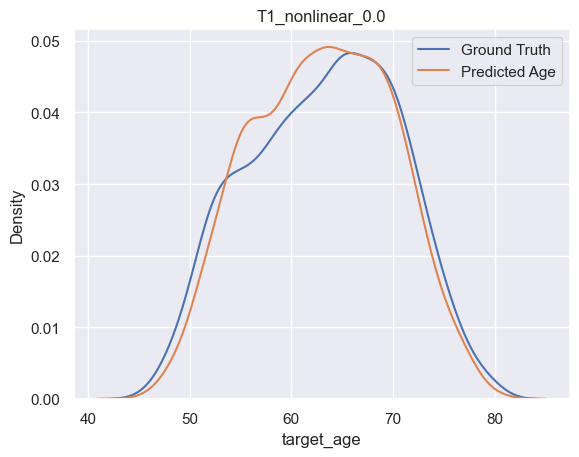

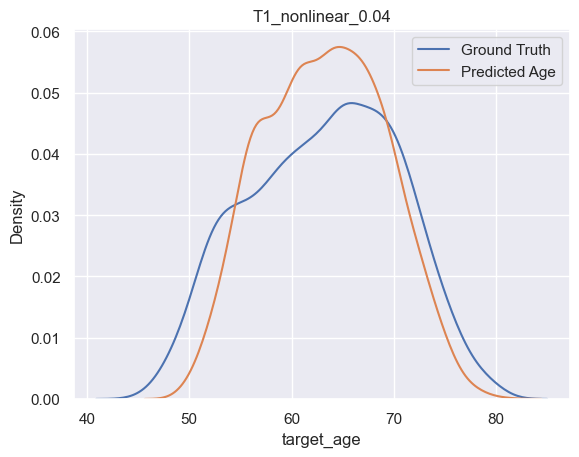

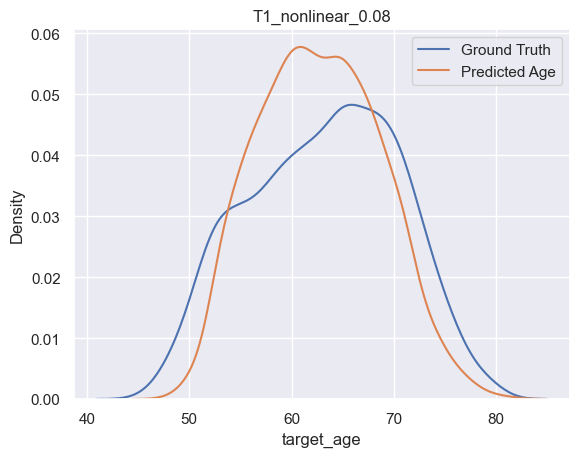

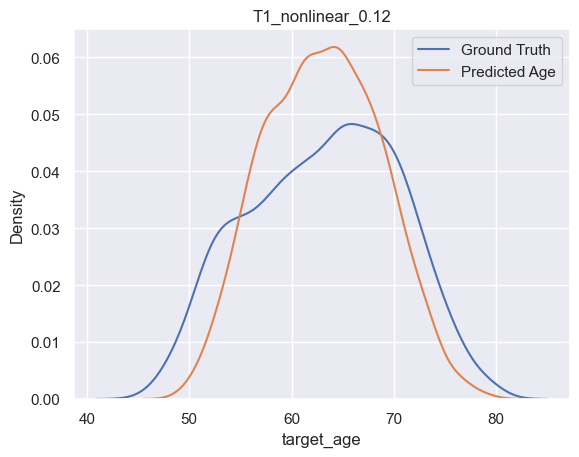

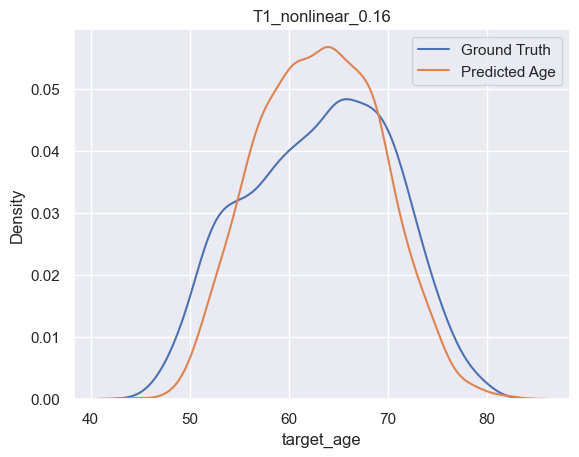

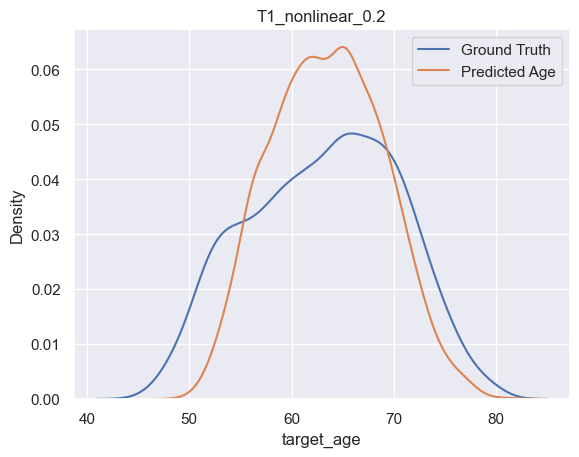

In [15]:
for idx in range(len(df1)):
    for idx2 in range(1,7):
        df_mod = df1.iloc[idx].dataframe
        name_mod = df1.iloc[idx].modality
        y_name = 'output_age_' + str(idx2)
#         y_name = 'output_age_decon_' + str(idx2)
#         y_name = 'age_delta_' + str(idx2)
#         y_name = 'age_delta_decon_' + str(idx2)
        fig = kde_plot(x=df_mod.target_age, y=df_mod[y_name], 
                   xlabel='Ground Truth', ylabel='Predicted Age',
                   title=name_mod+ '_' + str(noiseSTD[idx2-1]))



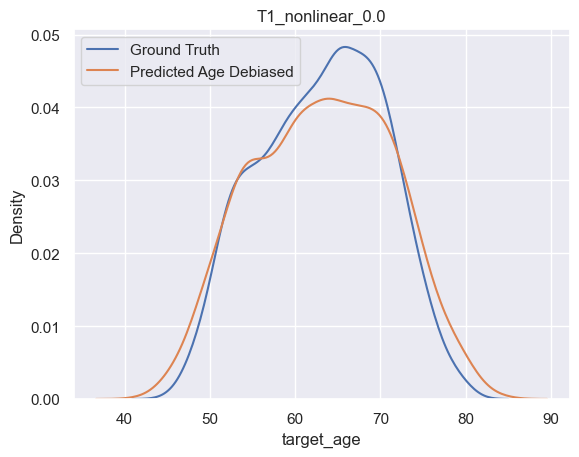

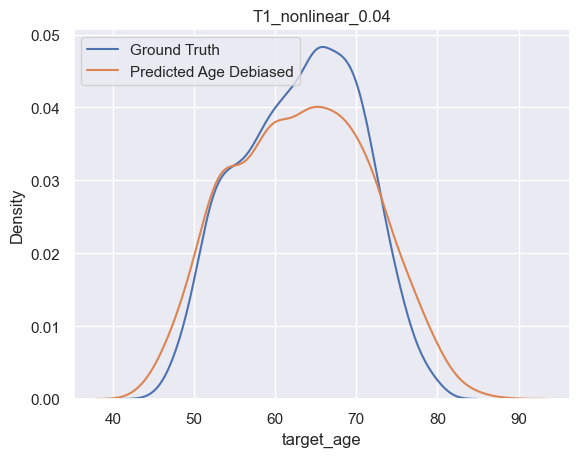

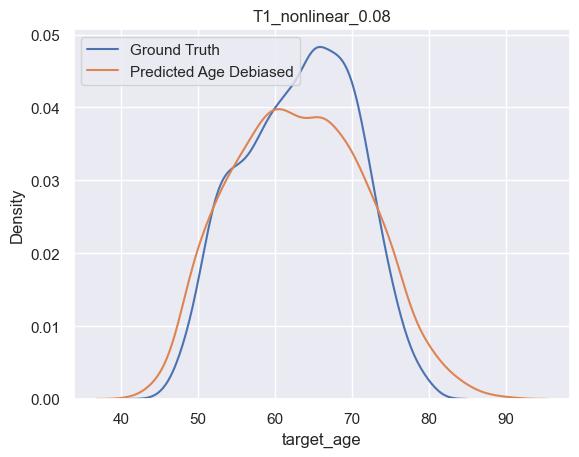

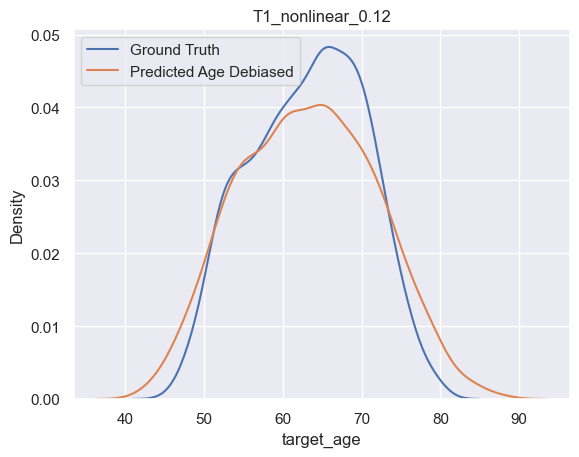

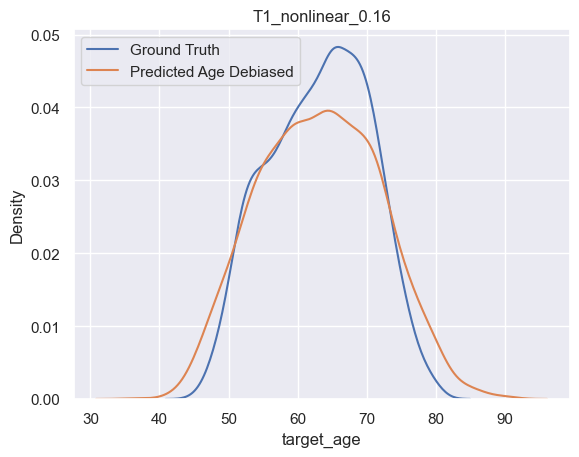

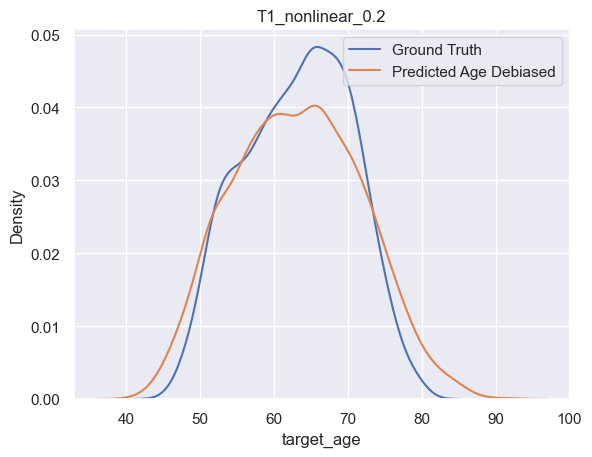

In [16]:
for idx in range(len(df1)):
    for idx2 in range(1,7):
        df_mod = df1.iloc[idx].dataframe
        name_mod = df1.iloc[idx].modality
#         y_name = 'output_age_' + str(idx2)
        y_name = 'output_age_decon_' + str(idx2)
#         y_name = 'age_delta_' + str(idx2)
#         y_name = 'age_delta_decon_' + str(idx2)
        fig = kde_plot(x=df_mod.target_age, y=df_mod[y_name], 
                   xlabel='Ground Truth', ylabel='Predicted Age Debiased',
                   title=name_mod+ '_' + str(noiseSTD[idx2-1]))


In [44]:
!ls '../../multi-age-mapper/Analysis Female - Variance Study'

1.1. Data Variance Study - Original Code Implementation.ipynb
1.2. Averages across young and old subjects + Difference Maps + Location Plots.ipynb
2.1. MAEs, MSEs, PR + Saving Pandas Dataframes - T1, T2, FA Convergence Study.ipynb
2.1.1. MAEs, MSEs, PR + Saving Pandas Dataframes - Single Modality 9-Run Convergence.ipynb
2.1.2. Correlation, Partial Correlation and Scatter Plots.ipynb
2.2. Data Variance Study - Converged Data Analysis - T1, T2, FA.ipynb
2.3. ElasticNet - Converged T1, T2, FA Results-Copy1.ipynb
2.3. ElasticNet - Converged T1, T2, FA Results.ipynb
2.3.1. ElasticNet - Converged Single Modality 9-Run Convergence.ipynb
2.3.2. ElasticNet - Converged T1, T2, FA Results - Using all 12 inputs to ElasticNet.ipynb
2.3.2.1. ElasticNet - Converged Single Modality 9-Run Convergence - Using all singleMod inputs.ipynb
2.4.1. UKB Correlation Analysis - Original vs Converged T1, T2, FA - with half B of Test Data.ipynb
2.4.1.1. UKB Correlation Analysis - Original vs Converged Single Modal